<a href="https://www.kaggle.com/code/syerramilli/ps3e10-xgboost-hyperopt?scriptVersionId=121710023" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This version of notebook is my preliminary attempt in training a XGBoost classifier (with hyperparameter tuning).

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

%matplotlib inline

In [2]:
curr_data_path = Path('/kaggle/input/playground-series-s3e10/')

train = pd.read_csv(curr_data_path/'train.csv')
test = pd.read_csv(curr_data_path/'test.csv')

del train['id']

train

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0
...,...,...,...,...,...,...,...,...,...
117559,132.843750,56.748838,-0.060070,-0.554084,4.054348,27.844144,6.564423,44.442664,0
117560,112.578125,52.539271,0.179580,-0.306961,1.637960,15.331913,11.384718,142.535470,0
117561,119.757812,49.980013,0.064402,-0.270822,3.877926,19.788559,6.959740,56.367789,0
117562,105.789062,46.986595,0.441426,0.372466,2.097826,17.170612,9.442445,99.074539,0


# Data visualization

First lets look at the class proportions.

In [3]:
train['Class'].value_counts(normalize=True)

0    0.906715
1    0.093285
Name: Class, dtype: float64

Clearly, this is a heavy class imbalance. However, the target metric for this competition is the log-loss, so must be careful when applying imbalance corrections such as class weighting or synthetic over-sampling. 

Next, we check if the columns have missing values. There aren't any. 

In [4]:
# check for missing values if any
train.isnull().sum()

Mean_Integrated         0
SD                      0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64

In [5]:
train.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000
mean,111.248300,46.713535,0.503498,1.886385,11.962921,26.190678,8.037488,93.881076,0.093285
std,24.906474,6.102941,1.127093,6.515466,26.719946,20.041937,3.840980,79.962110,0.290833
min,6.054688,24.783273,-1.730782,-1.791886,0.213211,7.370432,-2.597872,-1.976976,0.000000
25%,104.546875,43.443390,0.049761,-0.188956,2.090301,14.955405,6.742911,49.409136,0.000000
50%,116.664062,47.478932,0.186498,0.091720,2.808528,18.164924,8.442883,83.421375,0.000000
75%,126.296875,50.862718,0.395620,0.691613,4.122910,24.732218,10.003237,122.093290,0.000000
max,189.367188,93.602933,7.879628,65.385974,217.371238,109.890785,34.539844,1191.000837,1.000000


Now, we plot histograms of the different input features conditioned on the `Class`.

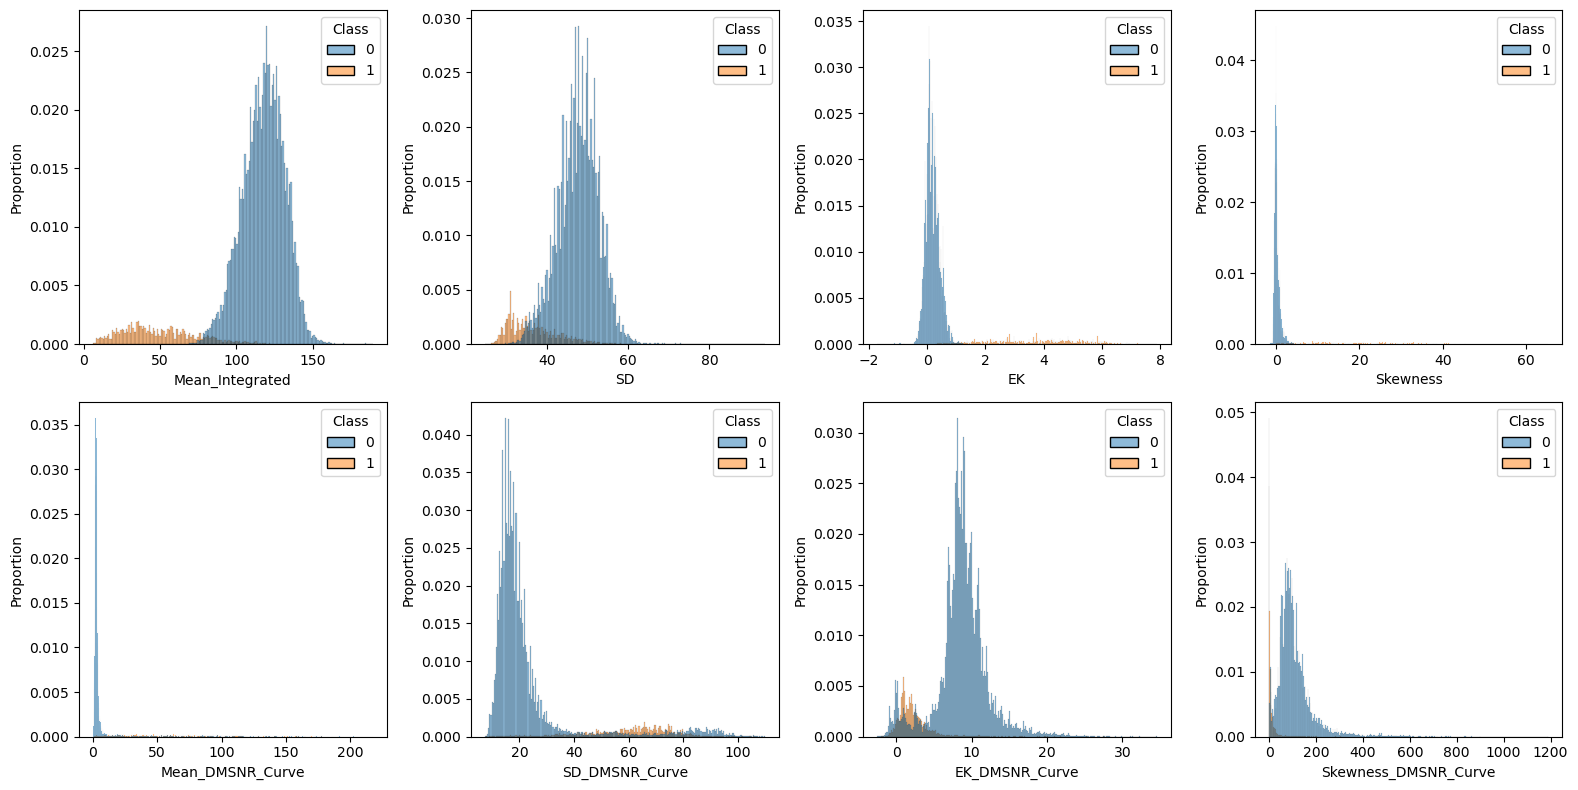

In [6]:
n_rows = 2
n_cols = 4

fig,axs = plt.subplots(n_rows,n_cols,figsize=(4*n_cols,4*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols*i+j
        _ = sns.histplot(
            data=train,x=train.columns[col_idx],ax=axs[i][j],hue='Class',stat='proportion'
        )
        
fig.tight_layout()

It is sort of hard to see any trends in part because of the larger number of outliers for many variables. It appears that `Mean_integrated` and `EK` are partly important. 

In the boxplots below, the separation is clear - although there are many outilers for Class 0

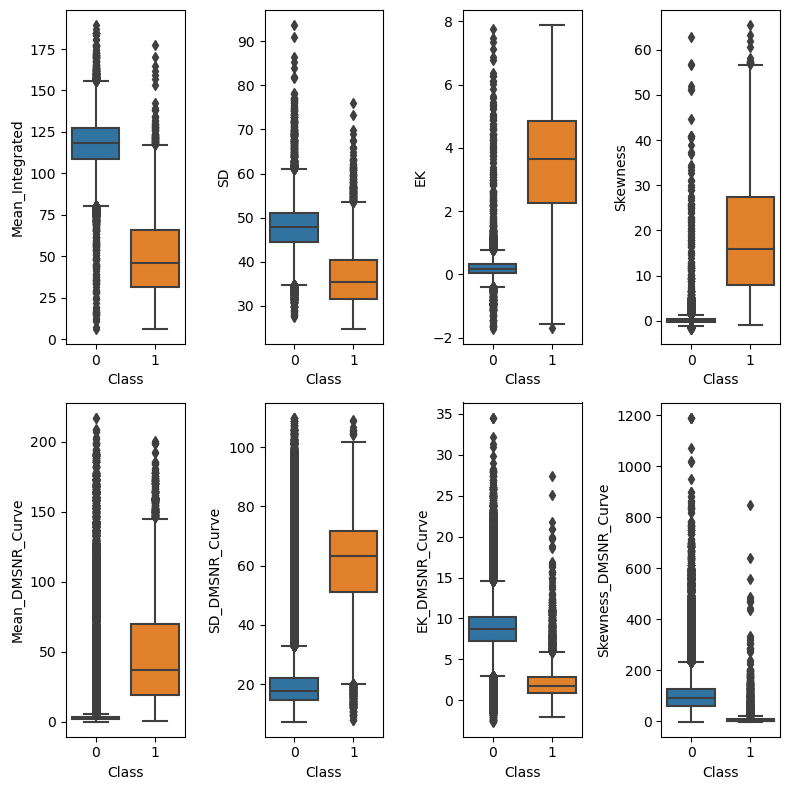

In [7]:
n_rows = 2
n_cols = 4

fig,axs = plt.subplots(n_rows,n_cols,figsize=(2*n_cols,4*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols*i+j
        _ = sns.boxplot(data=train,y=train.columns[col_idx],ax=axs[i][j],x='Class')
        
fig.tight_layout()

Let's add a new feature - log of the coefficient of variation. 

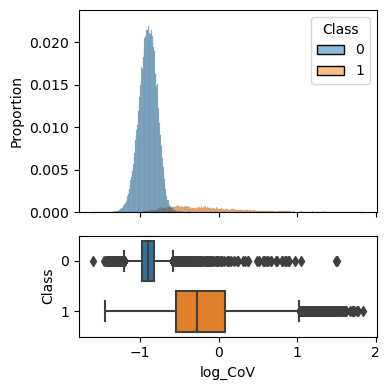

In [8]:
train['log_CoV'] = np.log(train['SD']/train['Mean_Integrated'])
test['log_CoV'] = np.log(test['SD']/test['Mean_Integrated'])

fig,axs = plt.subplots(2,1,figsize=(4,4),gridspec_kw={'height_ratios':[2,1]},sharex=True)
_ = sns.histplot(data=train,x='log_CoV',hue='Class',stat='proportion',ax=axs[0])
_ = sns.boxplot(data=train,x='log_CoV',y='Class',ax=axs[1],orient='h')


fig.tight_layout()

Before we go any further, let's check the Spearman rank correlations among the different predictors

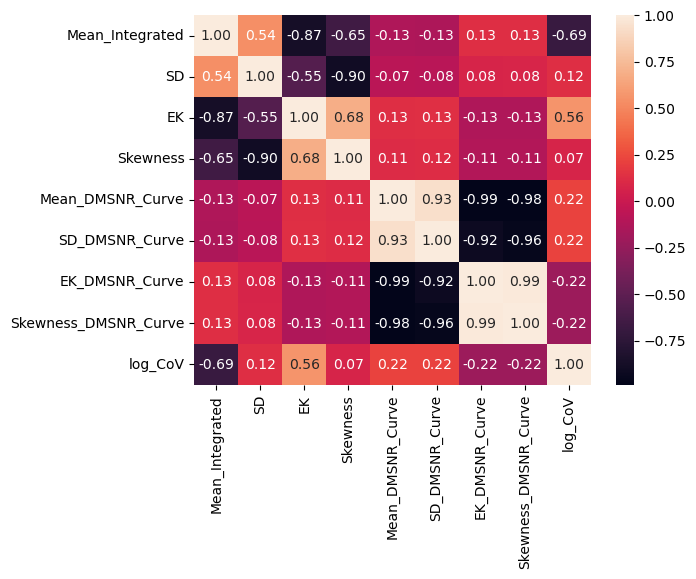

In [9]:
_ = sns.heatmap(
    train.drop('Class',axis=1).corr('spearman'),
    annot=True,
    fmt='.2f'
)

The`DMSNR_Curve` attributes appear to be very strongly correlated. Perhaps, their effects can be captured through lower dimensional latent variables. Likewise statistics on the observations are somwehat correlated with each other. For now, I won't utiltize this information.

In [10]:
# extract predictors
X = train.drop('Class',axis=1)
y = train['Class'].values

# XGboost model

## Training loop

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from typing import Optional,Dict


def fit_model_with_early_stopping(
    X:pd.DataFrame,
    y:np.ndarray,
    config:Optional[Dict]=None,
    n_jobs:int=1,
    verbose:int=0
) -> XGBClassifier:
    '''
    Train a XGboost classifier on the data with early stopping
    '''
    
    # split data into training and validation sets with stratification
    # on the labels
    # NOTE: this will add some randomness in the final results
    X_train,X_val, y_train, y_val = train_test_split(X,y,test_size=0.1,stratify=y)
    
    model = XGBClassifier(
        n_estimators = 1500, # use a large number of trees with early stopping
        tree_method='hist',#max_depth=0,
        early_stopping_rounds = 10,
        n_jobs=n_jobs
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
        
    return model.fit(
        X_train,y_train,eval_set=[(X_val, y_val)],
        verbose=verbose,
    )

## Tuning hyperparameters with hyperopt and 4-fold CV

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll_utils import scope

from joblib import Parallel, delayed

In [13]:
def fit_and_test_fold(config:Dict,train_index,test_index) -> float:
    X_train = X.iloc[train_index,:];X_test = X.iloc[test_index,:]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    model = fit_model_with_early_stopping(X_train,y_train,config)
    
    # generate predictions on test data
    test_prob = model.predict_proba(X_test)[:,-1]
    
    # return log-loss on held-out fold
    return log_loss(y_test,test_prob)

In [14]:
# loss function
def objective(config:Optional[Dict]=None):
     
    # 8-fold cross-validation: kaggle notebooks have 4 cores available
    cv = StratifiedKFold(n_splits=4,shuffle=True,random_state=1)
    
    cv_losses = Parallel(n_jobs=4,verbose=0)(
        delayed(fit_and_test_fold)(config,train_index,test_index) for train_index,test_index in cv.split(X,y)
    )
    
    return {'loss':np.mean(cv_losses),'status': STATUS_OK,'min_loss_fold':np.min(cv_losses),'max_loss_fold':np.max(cv_losses)}

# search space
search_space = {
    #'n_estimators': scope.int(hp.quniform('n_estimators',100,1500,1)),
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.5)),
    'max_depth': scope.int(hp.quniform('max_depth',1,12,1)), # default value is 6 
    'max_leaves': scope.int(hp.qloguniform('max_leaves',np.log(2),9*np.log(2),1)), # min: 2, max: 512
    'subsample':hp.uniform('subsample',0.1,1),
    'colsample_bytree':hp.uniform('colsample_bytree',0.1,1),
    'gamma':hp.loguniform('gamma',np.log(1e-6),np.log(100)),
    'reg_alpha':hp.loguniform('reg_alpha',np.log(1e-6),np.log(100)),
    'reg_lambda':hp.loguniform('reg_lambda',np.log(1e-6),np.log(100)),
    'grow_policy':hp.choice('grow_policy',['depthwise','lossguide']), # 'depthwise' is default
}


trials = Trials()
best = fmin(
    objective,search_space,
    algo=tpe.suggest,
    max_evals = 100,
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

100%|██████████| 100/100 [21:47<00:00, 13.08s/trial, best loss: 0.03150485800057652]


{'colsample_bytree': 0.46646319802159436,
 'gamma': 2.1767390763300414e-06,
 'grow_policy': 'lossguide',
 'learning_rate': 0.09456918600111651,
 'max_depth': 4,
 'max_leaves': 48,
 'reg_alpha': 0.6327934232322767,
 'reg_lambda': 54.208685222691294,
 'subsample': 0.89787888687543}

In [15]:
results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 

results['loss'] = [tmp['loss'] for tmp in trials.results]
results['min_loss_fold'] = [tmp['min_loss_fold'] for tmp in trials.results]
results['max_loss_fold'] = [tmp['max_loss_fold'] for tmp in trials.results]
results.to_csv('cv_rmse_hyperopt.csv',index=False)
# top 10 configurations
results.sort_values('loss',ascending=True).head(10)

,colsample_bytree,gamma,grow_policy,learning_rate,max_depth,max_leaves,reg_alpha,reg_lambda,subsample,loss,min_loss_fold,max_loss_fold
79,0.466463,0.000002,lossguide,0.094569,4,48,0.632793,54.208685,0.897879,0.031505,0.029751,0.033657
72,0.763808,0.000947,lossguide,0.092819,6,34,0.007265,96.423159,0.863304,0.031510,0.029512,0.033789
75,0.589500,0.000009,lossguide,0.037277,3,32,0.022016,65.195652,0.870050,0.031580,0.029903,0.033335
80,0.508874,0.000002,lossguide,0.090253,4,48,2.952855,57.450462,0.892715,0.031600,0.029947,0.033583
23,0.843156,0.003579,lossguide,0.026725,5,12,0.103295,1.659960,0.775336,0.031623,0.029926,0.033892
81,0.401276,0.000005,lossguide,0.250069,3,137,0.575064,74.559855,0.978330,0.031653,0.029896,0.033489
74,0.616927,0.000003,lossguide,0.037705,5,32,0.006470,92.112602,0.869799,0.031679,0.029882,0.033624
65,0.631367,0.000374,lossguide,0.019997,5,23,0.007967,12.850808,0.751131,0.031705,0.029722,0.034282
60,0.826077,0.021824,lossguide,0.101664,7,14,0.002068,5.171928,0.657392,0.031723,0.029783,0.034115
91,0.648522,0.000015,depthwise,0.074862,5,62,0.056970,11.481160,0.888478,0.031728,0.029630,0.033946


## Final model

**TODO:** Model calibration

In [16]:
# train model - print progress every 20 iterations
model = fit_model_with_early_stopping(X,y,best,verbose=20,n_jobs=4)

[0]	validation_0-logloss:0.60679
[20]	validation_0-logloss:0.10149
[40]	validation_0-logloss:0.04573
[60]	validation_0-logloss:0.03777
[80]	validation_0-logloss:0.03628
[100]	validation_0-logloss:0.03548
[120]	validation_0-logloss:0.03491
[140]	validation_0-logloss:0.03457
[160]	validation_0-logloss:0.03430
[180]	validation_0-logloss:0.03409
[200]	validation_0-logloss:0.03387
[220]	validation_0-logloss:0.03372
[240]	validation_0-logloss:0.03357
[260]	validation_0-logloss:0.03346
[280]	validation_0-logloss:0.03335
[300]	validation_0-logloss:0.03326
[320]	validation_0-logloss:0.03313
[340]	validation_0-logloss:0.03309
[360]	validation_0-logloss:0.03298
[373]	validation_0-logloss:0.03298


<AxesSubplot:>

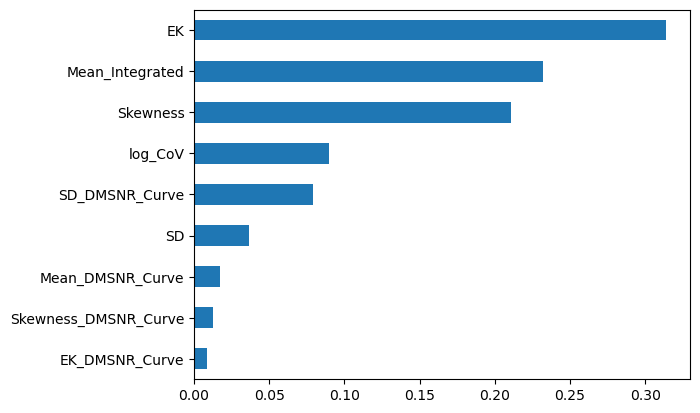

In [17]:
# gain based feature importances - not necessarily the most reliable
feat_imp = pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

# Evaluate on test set

In [18]:
submission = pd.DataFrame({'id':test['id'].values,'Class':model.predict_proba( test.drop('id',axis=1))[:,-1]})
submission.to_csv('submission.csv',index=False)